# IMPORTS

In [1]:
from novelty_detection.data import load_data, save_img, save_data
from novelty_detection.preprocessing import *
from novelty_detection.decision_plots import *

#load preprocessed data
data_to_load = "gaia_data_1.csv"
df_index = load_data(data_to_load, header_names=None, index=True)

# DATASET CREATION

Define columns to take into account. Remember that the target variable should be the rightmost column.

In [2]:
x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'T_ret',
           'Diff_temp',]# 'Day_week'] 

y_column = ['T_ret_in_1h']

all_columns = x_columns + y_column

We filter the dataset

In [3]:
df_index = filter_signal(df_index, ['T_ext', 'Solar_irrad', 'T_imp', 'BC1_power', 'BC2_power', 'T_ret'], 5)

We add new columns to the dataset

In [4]:
df_index['Diff_temp'] = df_index['T_imp'] - df_index['T_ret']
#df_index['Day_week'] = df_index.index.to_series().dt.dayofweek
df_index['T_ret_in_1h'] = df_index['T_ret'].shift(-30) # 1 hour is 30 rows, since between rows there is a 2 min interval
df_index = df_index.iloc[:-30]

We remove the day 25 of May because it was observed that it behaves differently w.r.t. the other days. We also change the ending hour to 17:30 instead of 18:30 because we want to predict the T_ret 1 hour into the future, so at 17:30 we will be predicting the T_ret at 18:30 (last working hour).

In [5]:
df_index = remove_specific_day(df_index, '2022-05-25')
dfs_day_working_hours = remove_non_working_hours(df_index, strating_hour='05:00', ending_hour='17:30')

Remove index datetime

In [6]:
dfs_anfis = []

for df_day in dfs_day_working_hours:
    df_day=df_day.reset_index().drop('datetime', axis=1)
    df_day['time'] = df_day.index
    dfs_anfis.append(df_day)

Use data of all days (time discontinuity)

In [7]:
data = pd.concat(dfs_anfis, ignore_index=True)
data.shape

(5640, 15)

Use only data of one day (time continuity)

In [8]:
chosen_day=1
data = dfs_anfis[1].copy()
data.shape

(376, 15)

# SPLIT

Following temporal continuity:

In [9]:
thresh= int(0.8*len(data))

train_x = data.loc[:thresh-1, x_columns]
train_y = data.loc[thresh:, x_columns]

test_x = data.loc[:thresh-1, y_column]
test_y = data.loc[thresh:, y_column]

print('training data shape: ', train_x.shape)
print('validation data shape: ', test_x.shape)

training data shape:  (300, 7)
validation data shape:  (300, 1)


Following random split (there will not be time continuty between rows, neither in training or validation data)

In [10]:
from sklearn.model_selection import train_test_split

X=data[x_columns]
y=data[y_column]

# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (300, 7)
y train shape:  (300, 1)
x test shape:  (76, 7)
x test shape:  (76, 1)


Following day continuity: like the firts n days for training and the last ones for validation. 

In [11]:
print('there is a total of', len(dfs_anfis), 'days')

there is a total of 15 days


In [12]:
split_day = 14
data_for_train = pd.concat(dfs_anfis[:split_day], ignore_index=True)
data_for_test = pd.concat(dfs_anfis[split_day:], ignore_index=True)

train_x = data_for_train[x_columns]
train_y = data_for_train[y_column]

test_x = data_for_test[x_columns]
test_y = data_for_test[y_column]

# SCALING

In [13]:
from novelty_detection.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters

mu_x = train_x.mean(0)
s_x = train_x.std(0)

mu_y = train_y.mean(0)
s_y = train_y.std(0)

train_x_norm = std_scaler_given_parameters(train_x, mu_x, s_x)
test_x_norm = std_scaler_given_parameters(test_x, mu_x, s_x)

train_y_norm = std_scaler_given_parameters(train_y, mu_y, s_y)
test_y_norm = std_scaler_given_parameters(test_y, mu_y, s_y)

# SAVE DATASET

In [16]:
save_data(train_x_norm, 'train_x.csv', data_type='processed', index=False, header=False)
save_data(test_x_norm, 'test_x.csv', data_type='processed', index=False, header=False)
save_data(train_y_norm, 'train_y.csv', data_type='processed', index=False, header=False)
save_data(test_y_norm, 'test_y.csv', data_type='processed', index=False, header=False)

# ANFIS TRAINING

In [22]:
from novelty_detection.anfis import ANFIS

# Example of use
fis = ANFIS(n_inputs=7, n_rules=5, learning_rate=7e-4, mf='gbellmf',defuzz_method='linear', loss_fun='huber', init_method='normal')
fis.compile(run_eagerly=True)

# For training
fis.fit(train_x_norm, train_y_norm, epochs=100, batch_size=32)

# For evaluation
val_loss = fis.evaluate(test_x_norm, test_y_norm)
print("Validation loss:", val_loss)

Epoch 1/100
165/165 [==============================] - 4s 24ms/step - loss: 1.0566
Epoch 2/100
165/165 [==============================] - 4s 24ms/step - loss: 0.4429
Epoch 3/100
165/165 [==============================] - 4s 24ms/step - loss: 0.4365
Epoch 4/100
165/165 [==============================] - 4s 23ms/step - loss: 0.4291
Epoch 5/100
165/165 [==============================] - 4s 23ms/step - loss: 0.4150
Epoch 6/100
165/165 [==============================] - 4s 23ms/step - loss: 0.4043
Epoch 7/100
165/165 [==============================] - 4s 23ms/step - loss: 0.3934
Epoch 8/100
165/165 [==============================] - 4s 23ms/step - loss: 0.3855
Epoch 9/100
165/165 [==============================] - 4s 23ms/step - loss: 0.3817
Epoch 10/100
165/165 [==============================] - 4s 23ms/step - loss: 0.3761
Epoch 11/100
165/165 [==============================] - 4s 24ms/step - loss: 0.3732
Epoch 12/100
165/165 [==============================] - 4s 24ms/step - loss: 0.3721
E

12/12 [==============================] - 0s 3ms/step


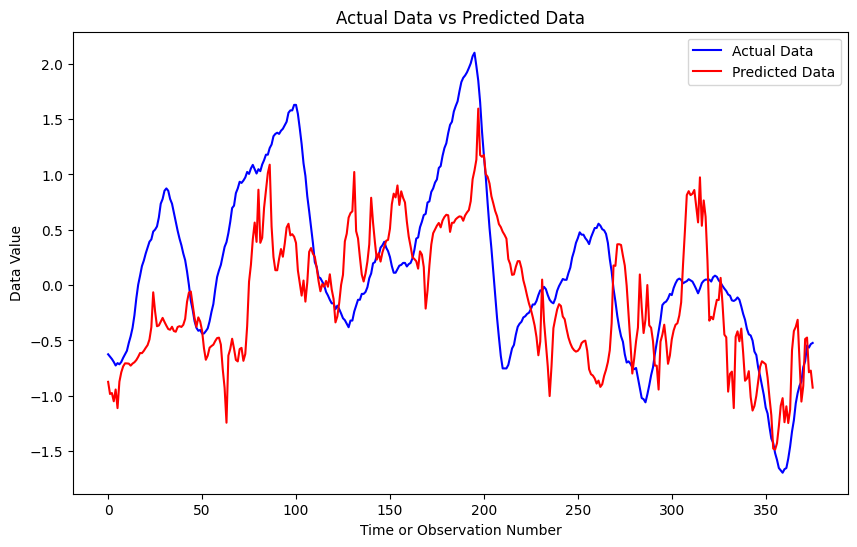

In [23]:
input_data = test_x_norm.to_numpy() 
time = np.arange(0,len(test_y))

# Generate predictions
predicted_data = fis.predict(input_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, test_y_norm, label='Actual Data', color='blue')
plt.plot(time, predicted_data, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()

# MLP

In [34]:
from keras.models import Sequential
from keras.layers import Dense

model_mlp=Sequential()
model_mlp.add(Dense(512,activation="relu",input_dim=train_x_norm.shape[1]))
model_mlp.add(Dense(128,activation="relu"))
model_mlp.add(Dense(1,activation="selu"))
model_mlp.compile(loss='mse',optimizer="adam")

history_mlp=model_mlp.fit(train_x_norm,train_y_norm,
                          epochs=1000,
                          validation_data=(test_x_norm,test_y_norm), 
                          batch_size=64)

Epoch 1/1000
83/83 [==============================] - 1s 3ms/step - loss: 0.7193 - val_loss: 0.5086
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6007 - val_loss: 0.5910
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5445 - val_loss: 0.6785
Epoch 4/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5110 - val_loss: 0.7037
Epoch 5/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4873 - val_loss: 0.7656
Epoch 6/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4772 - val_loss: 0.5994
Epoch 7/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4642 - val_loss: 0.5896
Epoch 8/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4380 - val_loss: 0.6573
Epoch 9/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4258 - val_loss: 0.7195
Epoch 10/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4151 - val_loss: 0.6293

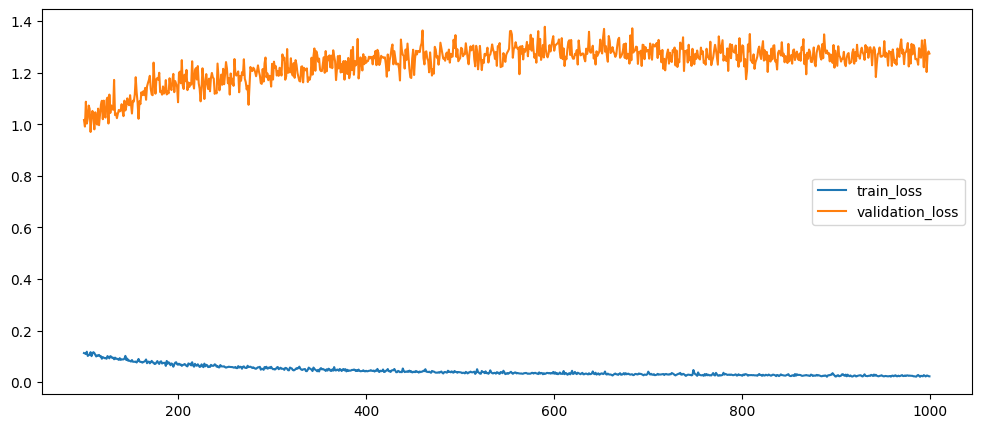

In [35]:
train_loss=history_mlp.history['loss']
val_loss=history_mlp.history['val_loss']
x = 100  
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(x, len(train_loss)), train_loss[x:], label='train_loss')
ax.plot(range(x, len(val_loss)), val_loss[x:], label='validation_loss')
ax.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step


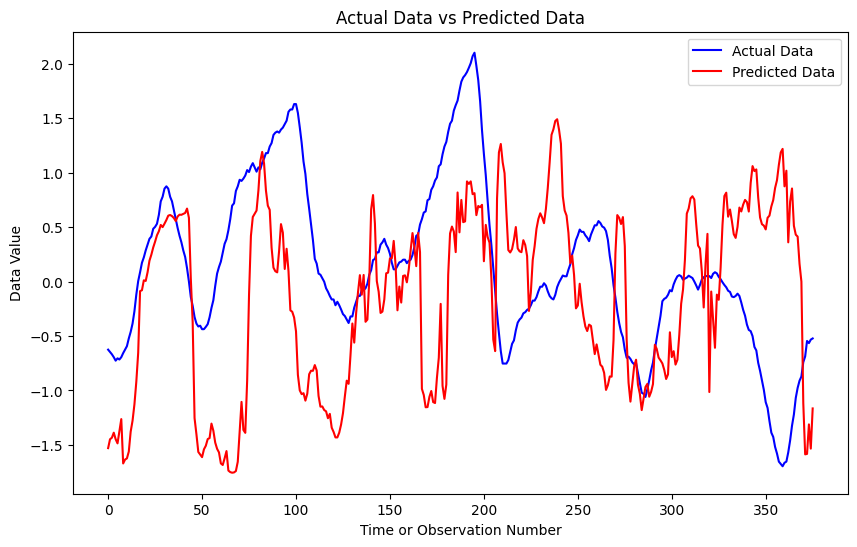

In [36]:
predict_mlp=model_mlp.predict(test_x_norm)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, test_y_norm, label='Actual Data', color='blue')
plt.plot(time, predict_mlp, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()

In [104]:
len(test_x_norm)

754

In [27]:
from sklearn.ensemble import RandomForestRegressor
 
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(train_x_norm, train_y_norm.to_numpy().ravel())

RandomForestRegressor(oob_score=True, random_state=0)

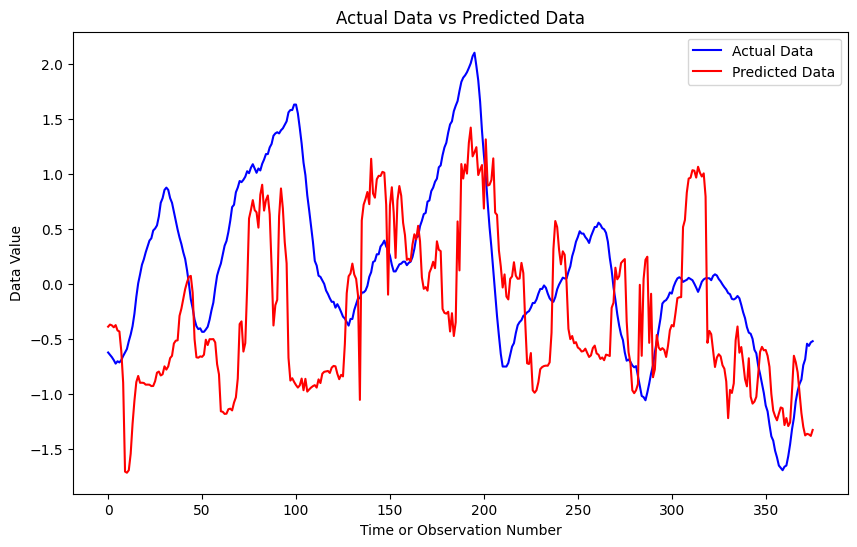

In [28]:
predictions = regressor.predict(test_x_norm)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, test_y_norm, label='Actual Data', color='blue')
plt.plot(time, predictions, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()